In [1]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants

import simdata

In [2]:
# very hard example

# simid = "4ae2169c"
# Noutput = 30

# hard example

# simid = "306d9f0c"
# Noutput = 52

# overlapping with boundary example

# simid = "9f976424"
# Noutput = 90

# elongated vortex example

# simid = "487fa644"
# Noutput = 222

# big vortex example
simid = "3625e016"
Noutput = 200

# easy example

# simid = "a122b63c"
# Noutput = 75

# # faint vortex
# simid = "65a701a4"
# Noutput = 380

# another faint vortex
# simid = "b522b88a"
# Noutput = 116

# no vortex

# simid = "3401c4d0"
# Noutput = 256

# 8cps x 2cps example

# simid = "65a701a4"
# Noutput = 50

# 16 cps example
# simid = "20ce240c"
# Noutput = 82 # overlapping with spiral, need 0.2 spacing in vortensity
# Noutput = 83
# Noutput = 84 # hard case barely passing

# easier 16 cps example
# simid = "71cfb245"
# Noutput = 54

simulation = simdata.SData(simid)

## Vorticity calculation for simdata

In [3]:
def map_angles(phi, phi_min=-np.pi):
    """ Map angles to the range [phi_min, phi_min + 2pi]

    Parameters
    ----------
    phi: float
        Angles to map.
    phi_min: float
        Lower bound.
    """
    phi_max = phi_min + 2*np.pi
    phi = phi % (2*np.pi)
    if isinstance(phi, np.ndarray):
        phi[phi > phi_max] -= 2*np.pi
    else:
        if phi > phi_max:
            phi -= 2*np.pi
    return phi


def vorticity_simdata(data, Noutput, rref=None):
    vrad = data.fluids["gas"].get("2d", "velocity radial", Noutput)
    rs = vrad.grid.get_centers("r")
    phi = vrad.grid.get_centers("phi")

    PHI, R = np.meshgrid(phi, rs)

    t = vrad.get_time()
    try:
        omega_frame = data.planets[0].get(
            "omega frame").get_closest_to_time(t).to("s-1")
    except KeyError:
        omega_frame = (1/data.loader.units["time"]).to("s-1")

    dvrad_dphi = derivative_vrad_phi(data, Noutput)
    duazi_dr, uazi = derivative_vazi_r(data, Noutput, rref=rref)

    vorticity = 2*omega_frame + uazi/R + duazi_dr - dvrad_dphi/R
    return vorticity


def derivative_vrad_phi(data, Noutput):
    vrad = data.fluids["gas"].get("2d", "velocity radial", Noutput)

    rsi = vrad.grid.get_coordinates("r")
    phii = vrad.grid.get_coordinates("phi")

    PHIi, Ri = np.meshgrid(phii, rsi)

    rsc = vrad.grid.get_centers("r")
    phic = vrad.grid.get_centers("phi")
    PHIc, Rc = np.meshgrid(phic, rsc)

    if data.loader.code_info[0].lower().startswith("fargo"):
        Rplus = Ri[1:, :]
        Rminus = Ri[:-1, :]
        vplus = vrad.data[1:, :]
        vminus = vrad.data[:-1, :]
        # interpolate to cell centers
        vr = vminus + (vplus - vminus)/(Rplus - Rminus)*(Rc-Rminus)
    elif data.loader.code_info[0].lower().startswith("pluto"):
        vr = vrad.data
    dvrad_dphi = np.gradient(vr.to_value('cm/s'), phic.to_value('rad'), axis=1)
    return dvrad_dphi*u.cm/u.s


def derivative_vazi_r(data, Noutput, rref=None):
    vazi = data.fluids["gas"].get("2d", "velocity azimuthal", Noutput)

    try:
        Mstar = data.planets[0].get("mass")[0]
    except KeyError:
        Mstar = 1*u.solMass
        print("Warning: Assumed a start mass of 1 solar mass!")

    if rref is not None:
        rref = rref*u.au
        v_K = np.sqrt(astropy.constants.G*Mstar/rref).to("cm/s")
        omega_frame = data.planets[0].get(
            "omega frame").get_closest_to_time(vazi.get_time()).to("s-1")
        v_Frame = omega_frame*rref
        v_azi_rot = vazi.data + v_Frame - v_K
    else:
        v_azi_rot = vazi.data

    rsi = vazi.grid.get_centers("r")
    phii = vazi.grid.get_interfaces("phi")

    PHIi, Ri = np.meshgrid(phii, rsi)
    rsc = vazi.grid.get_centers("r")
    phic = vazi.grid.get_centers("phi")
    PHIc, Rc = np.meshgrid(phic, rsc)

    PHIplus = PHIi[:, 1:]
    PHIminus = PHIi[:, :-1]
    vplus = np.roll(v_azi_rot, 1, axis=1)
    vminus = v_azi_rot

    va = vminus + (vplus - vminus)/(PHIplus - PHIminus)*(PHIc-PHIminus)

    dvazi_dr = np.gradient(va.to_value('cm/s'), rsc.to_value('cm'), axis=0)
    return dvazi_dr/u.s, va


def velocity_cartesian_simdata(data, Noutput):
    vrad = data.fluids["gas"].get("2d", "velocity radial", Noutput)
    vazi = data.fluids["gas"].get("2d", "velocity azimuthal", Noutput)

    rs = vrad.grid.get_centers("r")
    phi = vrad.grid.get_centers("phi")

    PHI, R = np.meshgrid(phi, rs)

    x = R*np.cos(PHI)
    y = R*np.sin(PHI)

    # centered velocities
    vrad_c = vrad.data[:-1, :]
    #vazi_c = vazi.data - np.tile(np.mean(vazi.data, axis=1), (vazi.data.shape[1], 1) ).transpose()
    G = astropy.constants.G
    try:
        Mstar = data.planets[0].get("mass")[0]
    except KeyError:
        Mstar = 1*u.solMass
        print("Warning: Assumed a start mass of 1 solar mass!")
    v_K = np.sqrt(G*Mstar/R).to("cm/s")
    v_Frame = 0.5*1.6792048484108891e-08*1/u.s*R
    vazi_c = vazi.data - v_K + v_Frame

    vx = vrad_c*np.cos(PHI) - vazi_c*np.sin(PHI)
    vy = vrad_c*np.sin(PHI) + vazi_c*np.cos(PHI)

    return (x, y, vx, vy)

In [4]:
M_star = 1*u.solMass
rho = simulation.fluids["gas"].get("2d", "mass density", Noutput)
r = rho.grid.get_centers("r")
phi = rho.grid.get_interfaces("phi")
phi = map_angles(phi.to_value("rad"))
if np.isclose(phi[-1],-np.pi):
    phi[-1] = np.pi
phi = phi*u.rad
PHI_rho, R_rho = np.meshgrid(phi, r)
x_rho = R_rho*np.cos(PHI_rho)
y_rho = R_rho*np.sin(PHI_rho)
phi_c = rho.grid.get_centers("phi")
phi_c = map_angles((phi_c).to_value("rad"))
if phi_c[-1] == 0.0:
    phi_c[-1] = 2*np.pi
phi_c = phi_c*u.rad
PHI_c, R_c = np.meshgrid(phi_c, r)
xc = R_c*np.cos(PHI_c)
yc = R_c*np.sin(PHI_c)

dr = rho.grid.get_sizes("r").to_value("au")
dphi = rho.grid.get_sizes("phi").to_value("rad")
DPHI, DR = np.meshgrid(dphi, dr)

In [5]:
vorticity = vorticity_simdata(simulation, Noutput)
Omega_Kepler = np.sqrt(astropy.constants.G * M_star / R_c**3).decompose()
vorticity_Kepler = (0.5*Omega_Kepler).to("1/s")
vorticity = vorticity.to_value(1/u.s)
vorticity = (vorticity/vorticity_Kepler).decompose().value

Rho_background = simulation.fluids["gas"].get("2d", "mass density", 0).data.to_value("solMass/au2")
Rho = simulation.fluids["gas"].get("2d", "mass density", Noutput).data.to_value("solMass/au2")
vortensity = vorticity/rho.data.to_value("solMass/au2")*Rho_background

vortensity[vortensity < -1] = -1

# vortensity = np.exp(vorticity)

In [6]:
X = R_rho.to_value("au")
Y = PHI_rho.to_value("rad")
Xc = R_c.to_value("au")
Yc = PHI_c.to_value("rad")
R = Xc
A = DR*R*DPHI

In [7]:
N_roll = -np.argmax(phi[1:] - phi[:-1] < 0)
X = np.roll(X, N_roll, axis=1)
Y = np.roll(Y, N_roll, axis=1)
Xc = np.roll(Xc, N_roll, axis=1)
Yc = np.roll(Yc, N_roll, axis=1)
vorticity = np.roll(vorticity, N_roll, axis=1)
vortensity = np.roll(vortensity, N_roll, axis=1)
Rho = np.roll(Rho, N_roll, axis=1)
Rho_background = np.roll(Rho_background, N_roll, axis=1)

## Test vortector class implementation

In [8]:
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler
from importlib import reload
from pprint import pprint
import vortector

In [9]:
levels = [float(x) for x in np.arange(-1,1.5,0.05)]
# levels = [float(x) for x in np.arange(-1,1.5,0.1)]

In [53]:
vd = vortector.Vortector(Xc, Yc, A, vortensity, Rho, Rho_background,
                         [5.2,12], verbose=False, med=0.15, mear=np.inf,
                         levels=levels
                        )
%time vortices = vd.detect_vortex(include_mask=True)
for v in vortices:
    v["strength"] = np.exp(-v["vortensity_median"])*v["mass"]
    print("strength = {:.2e}, mass = {:.2e} , min vort = {:.3f}".format(v['strength'],v['mass'],v['vortensity_min']))
# pprint(vortices)

CPU times: user 2.01 s, sys: 1.35 s, total: 3.35 s
Wall time: 3.33 s
strength = 1.09e-03, mass = 1.42e-03 , min vort = 0.044
strength = 1.70e-05, mass = 3.57e-05 , min vort = 0.722


In [54]:
#import cProfile
#cProfile.run("vd.detect_vortex(include_mask=True)", sort="cumtime")

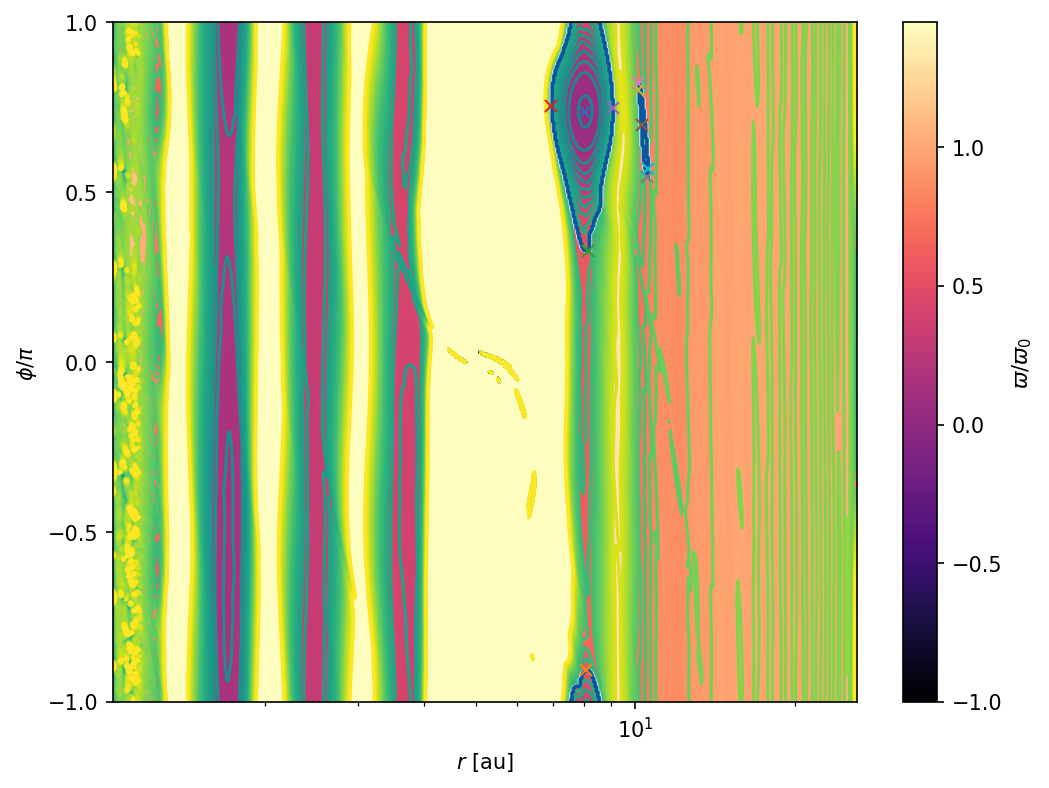

In [57]:
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(Xc, Yc/np.pi, vortensity,cmap=cmap,norm=norm, rasterized=True, shading="auto")

ax.contour(Xc, Yc/np.pi, vortensity, levels=levels)

show_bounding_lines = False
show_bounding_points = True

for n,vort in enumerate(vortices):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc, Yc/np.pi, vort["mask"], cmap="Blues")
    x,y = vort["vortensity_min_pos"]
    ax.plot([x],[y/np.pi],"x")
    
    if show_bounding_lines:
        for key in ["rmin", "rmax"]:
            ax.axvline(vort[key])
        for key in ["phimin", "phimax"]:
            ax.axhline(vort[key]/np.pi)

    if show_bounding_points:
        for key in ["top", "bottom", "left", "right"]:
            x = Xc[vort[key]]
            y = Yc[vort[key]]/np.pi
            ax.plot([x], [y], "x")

            
ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

# ax.set_xlim(5.2, 10)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\varpi/\varpi_0$")

Plot vortensity

In [13]:
xlims = [5.2, 10]

<ipython-input-14-f43c07e51f5a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(X,Y,Z,cmap=cmap,norm=norm)


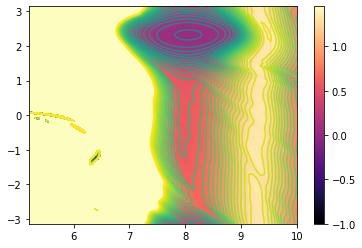

In [14]:
fig, ax = plt.subplots()
Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(X,Y,Z,cmap=cmap,norm=norm)
ax.set_xlim(xlims)
ax.contour(Xc, Yc, vortensity, levels=levels)

cbar = fig.colorbar(img, ax=ax)

Detect vortex

f_Sigma 2.0
threshold 0.5


<ipython-input-15-aadfc9b11623>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(X,Y,vortensity,cmap=cmap,norm=norm)


argmin ind 344952 inds (336, 888) x 8.040993987954765 y 2.3009711818284617 Zmin 0.04444395565676551
normalized Z 0.07799525531822527
ratio rho_avg / rho0 1.7549125447017313
ratio rho_max / rho0 5.308328992437491


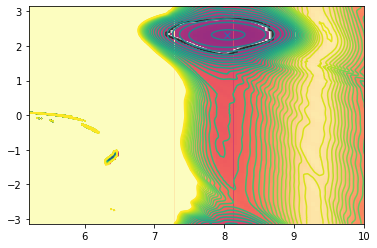

In [15]:
rmin = 5.2
rmax = 10

mask_loc_inner = R_c.to_value("au") < rmin
mask_loc_outer = R_c.to_value("au") > rmax
mask_loc = np.logical_or(mask_loc_inner, mask_loc_outer)


n_overshoot_vort = 2
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


n_overshoot_Sigma = 2
f_Sigmas = [2.0, 1.9, 1.8, 1.7, 1.6, 1.5]

for vorticity_th in thresholds:
    mask_vorticity = vorticity > vorticity_th
    for f_Sigma in f_Sigmas:
        mask_dens = Rho < f_Sigma * Rho_background
        mask = np.logical_or(mask_loc, mask_dens)
        mask = np.logical_or(mask, mask_vorticity)
        if np.sum(mask == 0) < 1000:
            continue
        else:
            if n_overshoot_Sigma <= 0:
                break
            else:
                n_overshoot_Sigma -= 1
                continue
    if np.sum(mask == 0) > 0:
        if n_overshoot_vort <= 0:
            print("f_Sigma",f_Sigma)
            print("threshold", vorticity_th)
            break
        else:
            n_overshoot_vort -= 1

vals = np.ma.masked_array(vortensity, mask=mask)

Zmin = np.min(vals)

ind = np.argmin(vals, axis=None)
inds = np.unravel_index(ind, vals.shape)
x = X[inds]
y = Y[inds]

fig, ax = plt.subplots()
img = ax.pcolormesh(X,Y,vortensity,cmap=cmap,norm=norm)
ax.contour(Xc, Yc, mask, cmap="Greys")
ax.contour(Xc, Yc, vortensity, levels=levels)

print("argmin", "ind", ind, "inds", inds, "x", x, "y", y, "Zmin", Zmin)
ax.plot(x, y, "x")
ax.set_xlim(xlims)

ix = inds[0]
iy = inds[1]
rho_avg = np.average(Rho[ix, :])
rho_max = np.max(Rho[ix, :])
rho0 = np.average(Rho_background[ix, :])

print("normalized Z", Zmin * rho_avg / rho0)
print("ratio rho_avg / rho0", rho_avg / rho0)
print("ratio rho_max / rho0", rho_max / rho0)

Detect closed regions in the contour plot

In [16]:
Rc = Xc
view_min = np.argmin(Rc[:,0] < xlims[0])
view_max = np.argmin(Rc[:,0] < xlims[1])
print(view_min, view_max)

265 372


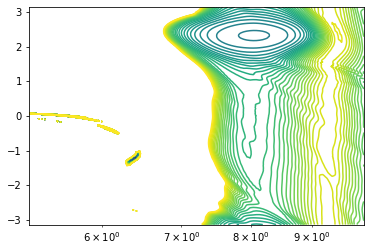

In [17]:
fig, ax = plt.subplots()
vmi = view_min
vma = view_max
img = ax.contour(Xc[vmi:vma,:], Yc[vmi:vma,:], vortensity[vmi:vma,:], levels=levels)
ax.set_xscale("log")

Make an image out of the contour lines

In [18]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

In [19]:
vmi = view_min
vma = view_max
data_view = vortensity[vmi:vma,:]

Nx, Ny = data_view.shape
int_aspect = int(np.max([Nx/Ny, Ny/Nx]))

if int_aspect >= 2:
    if Nx < Ny:
        CNx = int_aspect*Nx
        CNy = Ny
    else:
        CNx = Nx
        CNy = int_aspect*Ny

if min(CNx, CNy) < 1000:
    supersample = int(np.ceil(1000/min(CNx, CNy)))
else:
    supersample = 1

CNx *= supersample
CNy *= supersample
        
print(f"Nx {Nx}, Ny {Ny}, int_aspect {int_aspect}, supersample {supersample}, CNx {CNx}, CNy {CNy}")
        
fig = plt.figure(frameon=False, figsize=(CNx,2*CNy), dpi=1)
#fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

def periodically_extend(arr):
    Hhalf = int(arr.shape[1]/2)
    rv = np.concatenate(
        [arr[:,Hhalf:],
         arr,
         arr[:,:Hhalf]],
        axis=1
    )
    return rv
Zpe = periodically_extend(vortensity[vmi:vma,:])
Xpe = periodically_extend(Xc[vmi:vma,:])
Ype = periodically_extend(Yc[vmi:vma,:])

img = ax.contour(Zpe.transpose()
                 ,levels=levels, linewidths=CNx/1000, antialiased=False)

# ax.set_xlim(xlims)

# img = ax.contour(Xc[vmi:vma,:], Yc[vmi:vma,:], vortensity[vmi:vma,:]
#                  , levels=levels, linewidths=CNx/1000)

# ax.set_xscale("log")

# fig.canvas.draw()
# img_data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
# img_data = img_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
img_data = fig2rgb_array(fig)
img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
plt.close(fig)

Nx 107, Ny 1024, int_aspect 9, supersample 2, CNx 1926, CNy 2048


<ipython-input-18-669bc3611ab9>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)


In [20]:
img_data.shape

(4096, 1926)

## Threshold contour image for full contrast

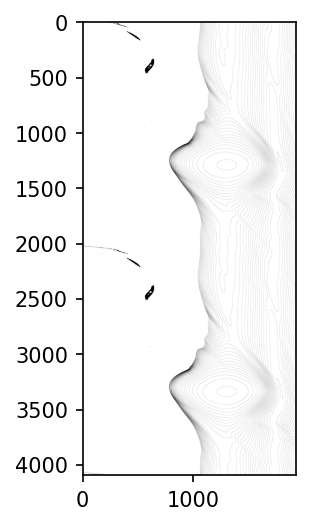

In [21]:
ret,thresh = cv2.threshold(img_data,250,255,0)
fig, ax = plt.subplots(dpi=150)
ax.imshow(thresh, cmap="Greys_r")

## Extract contours and construct hierarchy

In [22]:
# contours, hierarchy = cv2.findContours(
#         img_data, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("number of contours", len(contours))

contours_dict = { n : { "cnt" : cnt, "n" : n } for n, cnt in enumerate(contours) }

areas = [cv2.contourArea(c) for c in contours]
for n, d in enumerate(contours_dict.values()):
    d["area"] = areas[n]

sort_inds = np.argsort(areas)
ind_max = sort_inds[-1]
cnt_max = contours[ind_max]
contours_sorted = [contours_dict[i] for i in sort_inds]

# take the up to 100 largest patches
contours_largest = [contours_dict[i] for i in [n for n in sort_inds[::-1]][:100]]

number of contours 1273


## Extract closed contours

In [23]:
aspect_ratio_max = np.inf

contours_convex = []
for n, contour in enumerate(contours_largest):
    cnt = contour["cnt"]
    l = cv2.arcLength(cnt,True)
    contour["arcLength"] = l
    a = contour["area"]
    leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
    rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
    topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
    bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])
    dx = rightmost[0] - leftmost[0]
    dy = bottommost[1] - topmost[1]
    
    Nh = int(thresh.shape[0]/2)
    Nq = int(thresh.shape[0]/4)
    
    # sort out mirrors of contours fully contained in original area
    if bottommost[1] < Nq or topmost[1] > 3*Nq:
        continue

    is_not_too_elongated = dx >0 and dy >0 and max(dx/dy, dy/dx) < aspect_ratio_max
    is_area_larget_delimiter = l  > 0 and a > l
    is_not_spanning_whole_height = dy < 0.5*0.95*thresh.shape[0]

    if not(is_not_too_elongated and is_area_larget_delimiter and is_not_spanning_whole_height):
        continue
    
#     contours_convex.append(contour)
#     continue
    
    # sort out the lower of mirror images
    bounding_hor = np.array([ rightmost[0], leftmost[0]] )
    bounding_vert = np.array([ topmost[1], bottommost[1] ])
    contour["bottom_extended"] = bottommost
    contour["top_extended"] = topmost
    contour["left_extended"] = leftmost
    contour["right_extended"] = rightmost
    contour["bounding_hor"] = bounding_hor
    contour["bounding_vert"] = bounding_vert
    
    to_del = None
    found_mirror = False
    for k,c in enumerate(contours_convex):
        same_hor = (bounding_hor == c["bounding_hor"]).all()
        same_vert = (np.abs(bounding_vert % Nh - c["bounding_vert"] % Nh) < 20).all()
        if same_hor and same_vert:
            if bounding_vert[1] > c["bounding_vert"][1]:
                to_del = k
            found_mirror = True
            break
    
    if found_mirror:
        if to_del is not None:
            del contours_convex[to_del]
            contours_convex.append(contour)
    else:
        contours_convex.append(contour)
    
    
print("number of convex contours", len(contours_convex))

print([c["area"] for c in contours_convex])

# cv2.drawContours(dst, contours, -1, (255, 255, 0), -1)
# cv2.drawContours(dst, contours_convex, -1, (255, 255, 0), -1)

number of convex contours 42
[619253.5, 609601.5, 488326.0, 479912.5, 458178.5, 392795.5, 387585.0, 354419.5, 349553.0, 319865.5, 315291.5, 287859.0, 283522.5, 257121.5, 253043.5, 226387.5, 222546.5, 193043.5, 189456.5, 156970.0, 153739.0, 118260.0, 115447.0, 100508.0, 74673.5, 72433.5, 51753.0, 28899.5, 20301.5, 13677.0, 12717.5, 8396.0, 7427.5, 7062.0, 6364.5, 6058.5, 5535.5, 5488.0, 5287.5, 5233.0, 5107.0, 4498.5]


In [24]:
max_ellipse_deviation = 0.15

candidates = {}
for contour in contours_convex:
    cnt = contour["cnt"]
    ellipse = cv2.fitEllipse(cnt)
    
    im_shape = np.zeros(thresh.shape)
    cv2.drawContours(im_shape, [cnt], 0, (255, 255, 255), -1)

    im_ellipse = np.zeros(thresh.shape)
    im_ellipse = cv2.ellipse(im_ellipse,ellipse,(255,255,255),-1)
    
    difference = np.abs(im_shape - im_ellipse)
    difference_area = np.sum(difference/255)
    
    rel_delta = difference_area / contour["area"]
    
    
    if rel_delta > max_ellipse_deviation:
        continue
    
    contour["mask_extended"] = im_shape
    candidates[contour["n"]] = contour
    
    
#     fig, ax = plt.subplots(figsize=(6,4), dpi=150)
#     im = np.zeros(list(thresh.shape) + [3])
#     cv2.drawContours(im, [cnt], 0, (255, 255, 255), -1)
    
#     im = cv2.ellipse(im,ellipse,(255,0,0),4)
#     ax.imshow(im, cmap = 'gray', interpolation = 'bicubic')
    
#     n = contour["n"]
#     ax.set_title(f"{n}, delta area = {difference_area}, rel delta area {rel_delta:.3f}")

print([c["area"] for c in candidates.values()])

[392795.5, 387585.0, 354419.5, 349553.0, 319865.5, 315291.5, 287859.0, 283522.5, 257121.5, 253043.5, 226387.5, 222546.5, 193043.5, 189456.5, 156970.0, 153739.0, 118260.0, 115447.0, 74673.5, 72433.5, 13677.0, 12717.5]


(1307, 2976) (1329, 3761)


Text(0.5, 1.0, 'mask_reduced (2048, 1926)')

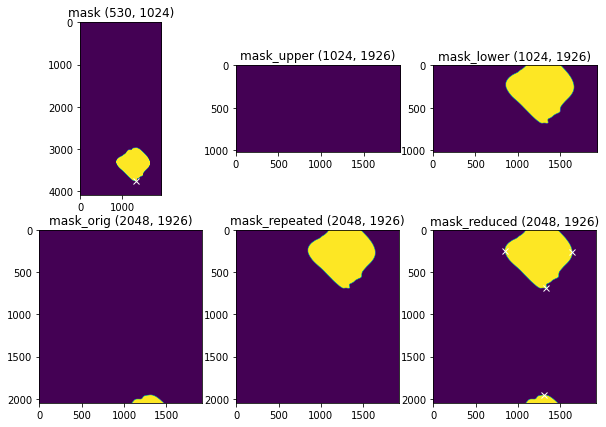

In [25]:
candidate_list = [c for c in candidates.values()]
c = candidate_list[0]
mask_extended = c["mask_extended"]
# reduce back to normal image size
Nh = int(mask_extended.shape[0]/2)
Nq = int(mask_extended.shape[0]/4)
mask_lower = mask_extended[3*Nq:, :]
mask_upper = mask_extended[:Nq, :]
mask_repeated = np.concatenate([mask_lower, mask_upper])
mask_orig = mask_extended[Nq:3*Nq, :]
mask_reduced = np.logical_or(mask_orig, mask_repeated)

cnt = c["cnt"]
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

print(topmost, bottommost)

fig, axes = plt.subplots(2,3, figsize=(10,7))
axes = axes.ravel()

axes[0].imshow(mask_extended)
x = bottommost[0]
y = bottommost[1]
axes[0].plot([x],[y], "x", color="white")


axes[1].imshow(mask_upper)
axes[2].imshow(mask_lower)
axes[3].imshow(mask_orig)
axes[4].imshow(mask_repeated)

def map_ext_pnt_to_orig(pnt):
    x = pnt[0]
    y = pnt[1]
    if y > Nq and y <= 3*Nq:
        y -= Nq
    elif y < Nq:
        y += Nq
    elif y > 3*Nq:
        y -= 3*Nq
    return (x,y)
    
axes[5].imshow(mask_reduced)
x, y = map_ext_pnt_to_orig(bottommost)
axes[5].plot([x],[y], "x", color="white")
x, y = map_ext_pnt_to_orig(topmost)
axes[5].plot([x],[y], "x", color="white")
x, y = map_ext_pnt_to_orig(leftmost)
axes[5].plot([x],[y], "x", color="white")
x, y = map_ext_pnt_to_orig(rightmost)
axes[5].plot([x],[y], "x", color="white")


# set titles
axes[0].set_title(f"mask {mask.shape}")
axes[1].set_title(f"mask_upper {mask_upper.shape}")
axes[2].set_title(f"mask_lower {mask_lower.shape}")
axes[3].set_title(f"mask_orig {mask_orig.shape}")
axes[4].set_title(f"mask_repeated {mask_repeated.shape}")
axes[5].set_title(f"mask_reduced {mask_reduced.shape}")

## Transform the image from ellipse fitting images back to match the grid

In [76]:
Nh = int(mask_extended.shape[0]/2)
Nq = int(mask_extended.shape[0]/4)
def map_ext_pnt_to_orig(pnt):
    x = pnt[0]
    y = pnt[1]
    if y > Nq and y <= 3*Nq:
        y -= Nq
    elif y < Nq:
        y += Nq
    elif y > 3*Nq:
        y -= 3*Nq
    return (x,y)

for contour in candidates.values():
    mask_extended = contour["mask_extended"]
    # reduce back to normal image size
    Nh = int(mask_extended.shape[0]/2)
    Nq = int(mask_extended.shape[0]/4)
    mask_lower = mask_extended[3*Nq:, :]
    mask_upper = mask_extended[:Nq, :]
    mask_repeated = np.concatenate([mask_lower, mask_upper])
    mask_orig = mask_extended[Nq:3*Nq, :]
    mask_reduced = np.logical_or(mask_orig, mask_repeated)
    
    # fit back to original data shape
    mask = mask_reduced.transpose()[:,::-1]
    mask = mask[::supersample,::supersample]
    if int_aspect >= 2:
        if Nx < Ny:
            mask = mask[::int_aspect,:]
        else:
            mask = mask[:,::int_aspect]
    mask = np.array(mask, dtype=bool)
    contour["mask"] = mask
    
    for key in ["bottom", "top", "left", "right"]: 
        pnt = contour[key + "_extended"]
        x, y = map_ext_pnt_to_orig(pnt)
        y = Nh - y
        x /= supersample
        y /= supersample
        if Nx < Ny:
            x /= int_aspect
        else:
            y /= int_aspect
        x = int(x)
        y = int(y)
        contour[key + "_view"] = (x,y)
        contour[key] = (x + vmi, y)
        

## Calculate mass of cells

In [77]:
mass = A*Rho

mass_background = A*Rho_background

mass_view = mass[vmi:vma,:]
mass_background_view = mass_background[vmi:vma,:]
vortensity_view = vortensity[vmi:vma,:]
vorticity_view = vorticity[vmi:vma,:]

Xc_view = Xc[vmi:vma,:]
Yc_view = Yc[vmi:vma,:]
Rho_view = Rho[vmi:vma,:]

## Show the candidates

<ipython-input-79-cbb0d62cadf6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)


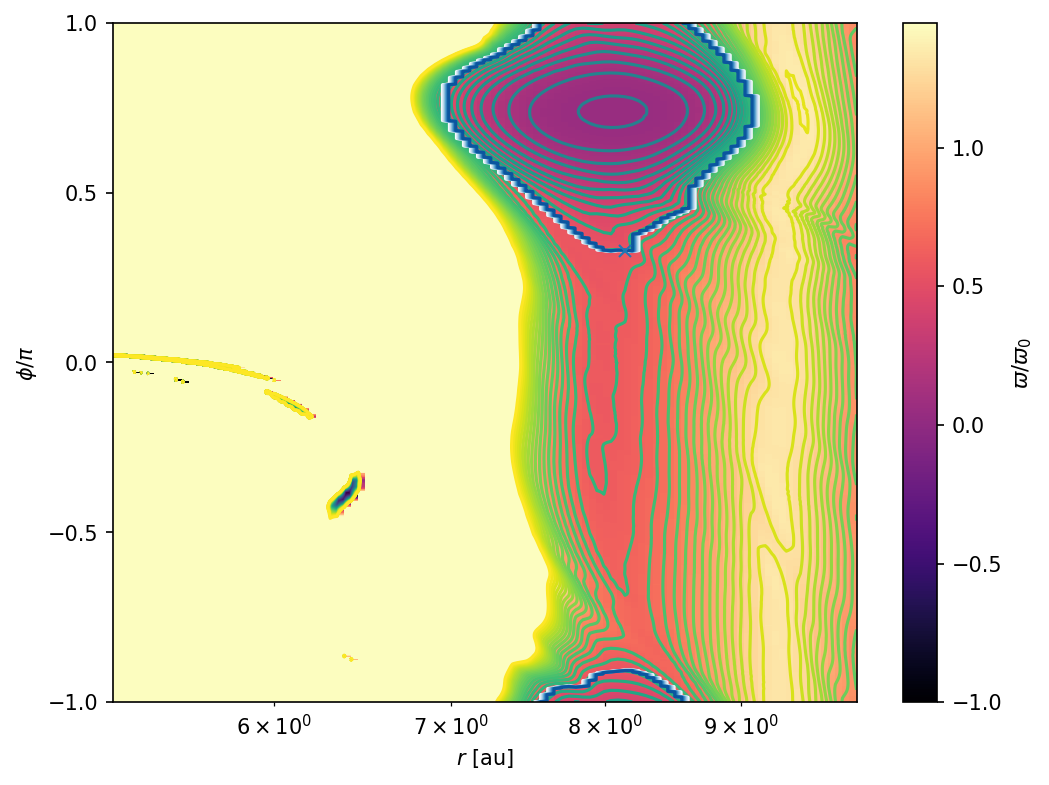

In [79]:
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)

ax.contour(Xc_view, Yc_view/np.pi, vortensity_view, levels=levels)

for n, contour in enumerate(candidates.values()):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc_view, Yc_view/np.pi, contour["mask"], cmap="Blues")
    ix, iy = contour["bottom_view"]
    x = Xc_view[ix, iy]
    y = Yc_view[ix, iy]
    ax.plot([x], [y/np.pi], "x")
    
ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\varpi/\varpi_0$")

## Generate ancestor list 

The hierarchy generated by opencv in the contour finder outputs a list with the syntax
```
[Next, Previous, First_Child, Parent]
```
If any of those is not available its encoded  by -1.

In [80]:
for c in candidates.values():
    ancestors = []
    n_parent = c["n"]
    for n in range(1000):
        n_parent = hierarchy[0,n_parent,3]
        if n_parent == -1 or n_parent not in candidates:
            break
        ancestors.append(n_parent)
    c["ancestors"] = ancestors
    print(c["n"], ancestors)

538 []


## Construct decendents from ancestor list
This is done to avoid causing trouble when an intermediate contour is missing.

In [81]:
decendents = {}
for c in candidates.values():
    ancestors = c["ancestors"]
    for k, n in enumerate(ancestors):
        if not n in decendents or len(decendents[n]) < k:
            decendents[n] = [i for i in reversed(ancestors[:k])]

for c in candidates.values():
    if c["n"] in decendents:
        dec = decendents[c["n"]]
    else:
        dec = []
    c["decendents"] = dec
    print(c["n"], dec)

538 []


## Remove children from candidates 

In [82]:
decendents = []
for c in candidates.values():
    decendents += c["decendents"].copy()
decendents = set(decendents)
candidates_bak = candidates.copy()
for n in decendents:
    del candidates[n]

## Get the mass and vortensity inside the candidates

In [83]:
for contour in candidates.values():
    try:
        mask = contour["mask"]
        contour["mass"] = np.sum(mass_view[mask])
        contour["mass_background"] = np.sum(mass_background_view[mask])
        contour["mass_enhancement"] = contour["mass"] - contour["mass_background"]
        contour["vortensity_mean"] = np.mean(vortensity_view[mask])
        contour["vortensity_median"] = np.median(vortensity_view[mask])
        contour["vortensity_min"] = np.min(vortensity_view[mask])
        contour["vortensity_max"] = np.max(vortensity_view[mask])
        contour["sigma_mean"] = np.mean(Rho_view[mask])
        contour["sigma_median"] = np.median(Rho_view[mask])
        contour["sigma_min"] = np.min(Rho_view[mask])
        contour["sigma_max"] = np.max(Rho_view[mask])
        
        
        contour["rmin"] = Xc_view[contour["left_view"]]
        contour["rmax"] = Xc_view[contour["right_view"]]
        contour["phimax"] = Yc_view[contour["top_view"]]
        contour["phimin"] = Yc_view[contour["bottom_view"]]
        contour["width"] = contour["rmax"] - contour["rmin"]
        if contour["phimax"] < contour["phimin"]:
            contour["height"] = contour["phimax"] + 2*np.pi - contour["phimin"]
        else:
            contour["height"] = contour["phimax"] - contour["phimin"]

    except (ValueError, KeyError):
        pass

IndexError: index 312 is out of bounds for axis 0 with size 107

## Remove candidates without vortensity min in center
A vortex should have at least a small dip in vortensity.
Exclude vortices for which the minimum vorticity is not at least 0.05 lower than the maximum vorticity.
Also check that vortensity < 1

In [68]:
min_vortensity_drop = 0.05
no_min = []
for n,c in candidates.items():
    cid = c["n"]
    if c["vortensity_min"] > 1:
        no_min.append(n)
        print(f"excluding {c['n']} because of min_vortensity > 1")
        continue
    vortensity_drop = c["vortensity_max"] - c["vortensity_min"]
    if vortensity_drop < min_vortensity_drop:
        cn = c["n"]
        print(f"excluding {cn} vortensity drop is {vortensity_drop} < {min_vortensity_drop}")
        no_min.append(n)
for n in no_min:
    del candidates[n]

## Calculate the position of minimum vortensity

In [69]:
for contour in candidates.values():
    mask = np.logical_not(contour["mask"])
    ind = np.argmin(np.ma.masked_array(vortensity_view, mask=mask), axis=None)
    inds = np.unravel_index(ind, vals.shape)
    x = Xc_view[inds]
    y = Yc_view[inds]
    contour["vortensity_min_pos"] = (x, y)
    contour["vortensity_min_inds"] = inds
    # print(f"(x,y) = ({x}, {y})")

## Calculate the position of maximum density

In [70]:
for contour in candidates.values():
    mask = np.logical_not(contour["mask"])
    ind = np.argmax(np.ma.masked_array(Rho_view, mask=mask), axis=None)
    inds = np.unravel_index(ind, vals.shape)
    x = Xc_view[inds]
    y = Yc_view[inds]
    contour["sigma_max_pos"] = (x, y)
    contour["sigma_max_inds"] = inds
    # print(f"(x,y) = ({x}, {y})")

## Sort vortices by mass

In [71]:
mass_sorted = [key for key in candidates]
mass_sorted = sorted(mass_sorted, key=lambda n: candidates[n]["mass"])
candidates = {n : candidates[n] for n in reversed(mass_sorted)}

## Remove duplicates by min vort location

In [72]:
to_del = []
for c in candidates.values():
    inds = c["vortensity_min_inds"]
    mass = c["mass"]
    
    for key, o in candidates.items():
        o_inds = o["vortensity_min_inds"]
        o_mass = o["mass"]
        if o_inds == inds and o_mass < mass:
            to_del.append(key)
for key in set(to_del):
    del candidates[key]

## Plot the vortex candidates on top of the vortensity data

<ipython-input-73-57073669dd8a>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)


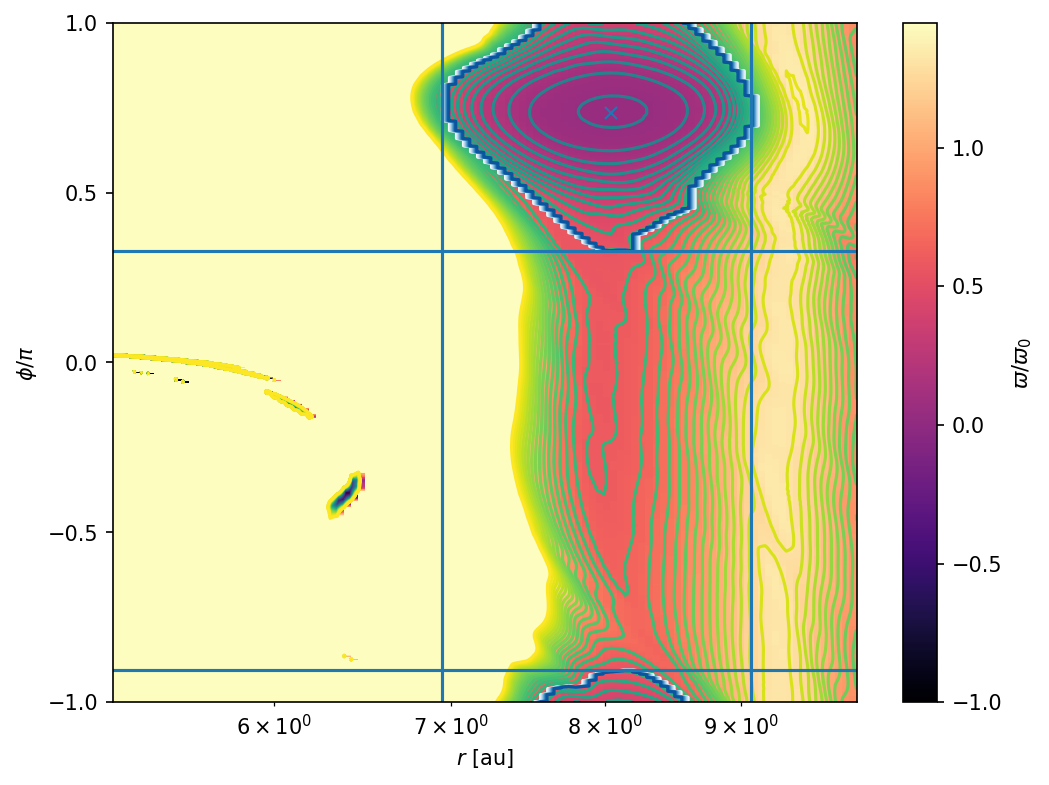

In [73]:
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)

candidates_list = [c for c in candidates.values()]
candidates_bak_list = [c for c in candidates_bak.values()]

# for contour in candidates_bak_list:
#     ax.contour(Xc[vmi:vma,:], Yc[vmi:vma,:], contour["mask"])

ax.contour(Xc_view, Yc_view/np.pi, vortensity_view, levels=levels)

for n, contour in enumerate(candidates_list):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc_view, Yc_view/np.pi, contour["mask"], cmap="Blues")
    x,y = contour["vortensity_min_pos"]
    ax.plot([x], [y/np.pi], "x")
    for key in ["rmin", "rmax"]:
        ax.axvline(contour[key])
    for key in ["phimin", "phimax"]:
        ax.axhline(contour[key]/np.pi)

ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\varpi/\varpi_0$")

## Print out some properties

In [74]:
from pprint import pprint
for vort in candidates.values():
    try:
#         for v in ["mass_enhancement", "mass_background", 
#                   "mass", "vortensity_min", "vortensity_median", 
#                   "vortensity_mean", "vortensity_max",
#                   "vortensity_min_inds", "n",
#                   "bounding_hor", "bounding_vert"]:
#             print(v, vort[v])
        mass = vort["mass"]
        pprint(vort)
        vort_med = vort["vortensity_median"]
        print([x % Nh for x in vort["bounding_vert"]])
        print("strength", np.exp(-vort_med)*mass)
    except KeyError:
        pass
    print()
    
    

{'ancestors': [],
 'arcLength': 2485.0146156549454,
 'area': 392795.5,
 'bottom': (73, 679),
 'bottom_extended': (1329, 3761),
 'bounding_hor': array([1645,  850], dtype=int32),
 'bounding_vert': array([2976, 3761], dtype=int32),
 'cnt': array([[[1306, 2977]],

       [[1307, 2976]],

       [[1308, 2976]],

       ...,

       [[1303, 2977]],

       [[1304, 2977]],

       [[1305, 2977]]], dtype=int32),
 'decendents': [],
 'gbottom': (338, 679),
 'gleft': (312, 897),
 'gmask': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
 'gright': (356, 894),
 'gtop': (337, 48),
 'height': 2.411417798556228,
 'left': (47, 897),
 'left_extended': (850, 3326),
 'mask': array([[False, False, False, ...,

## Calculate the center of gravity of the vortex

mass_enhancement 0.0008915902127043153
mass_background 0.0005302820006752395
mass 0.0014218722133795547
vortensity_min 0.04444395565676551
vortensity_median 0.2605463548748242
vortensity_mean 0.277083087043582
vortensity_max 0.6770567312109055
strength 1.147857341450551


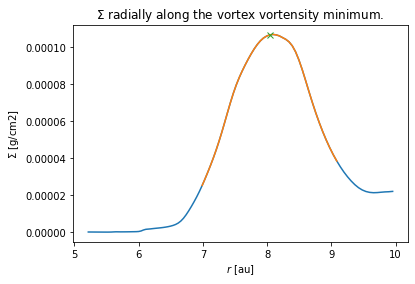

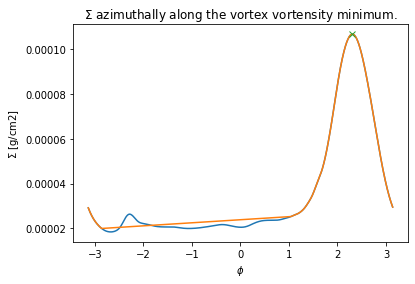

In [40]:
for vort in candidates.values():
    for v in ["mass_enhancement", "mass_background", "mass", "vortensity_min", "vortensity_median", "vortensity_mean", "vortensity_max"]:
        print(v, vort[v])
    mass = vort["mass"]/(1*u.jupiterMass).to_value("solMass")
    vort_med = vort["vortensity_median"]
    print("strength", np.exp(-vort_med)*mass)
    
    inds = contour["vortensity_min_inds"]
    
    mask = contour["mask"]
    mask_r = mask[:, inds[1]]
    mask_phi = mask[inds[0], :]
    
    sigma_r = Rho_view[:, inds[1]]
    sigma_phi = Rho_view[inds[0], :]
    
    fig, ax = plt.subplots()
    ax.plot(Xc_view[:,inds[1]], sigma_r)
    ax.plot(Xc_view[:,inds[1]][mask_r], sigma_r[mask_r])
    ax.plot([Xc_view[inds]],[Rho_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$\Sigma$ [g/cm2]")
    ax.set_title(r"$\Sigma$ radially along the vortex vortensity minimum.")
    
    fig, ax = plt.subplots()
    ax.plot(Yc_view[inds[0],:], sigma_phi)
    ax.plot(Yc_view[inds[0],:][mask_phi], sigma_phi[mask_phi])
    ax.plot([Yc_view[inds]],[Rho_view[inds]], "x")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\Sigma$ [g/cm2]")
    ax.set_title(r"$\Sigma$ azimuthally along the vortex vortensity minimum.")
    break
    

## Vortensity slices onto the vortex

mass_enhancement 0.0008915902127043153
mass_background 0.0005302820006752395
mass 0.0014218722133795547
vortensity_min 0.04444395565676551
vortensity_median 0.2605463548748242
vortensity_mean 0.277083087043582
vortensity_max 0.6770567312109055
strength 1.147857341450551


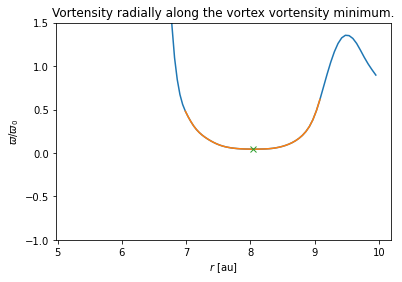

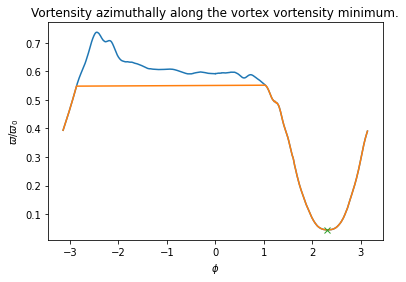

In [41]:
for vort in candidates.values():
    for v in ["mass_enhancement", "mass_background", "mass", "vortensity_min", "vortensity_median", "vortensity_mean", "vortensity_max"]:
        print(v, vort[v])
    mass = vort["mass"]/(1*u.jupiterMass).to_value("solMass")
    vort_med = vort["vortensity_median"]
    print("strength", np.exp(-vort_med)*mass)
    
    inds = contour["vortensity_min_inds"]
    
    mask = contour["mask"]
    mask_r = mask[:, inds[1]]
    mask_phi = mask[inds[0], :]
    
    vortensity_r = vortensity_view[:, inds[1]]
    vortensity_phi = vortensity_view[inds[0], :]
    
    fig, ax = plt.subplots()
    ax.plot(Xc_view[:,inds[1]], vortensity_r)
    ax.plot(Xc_view[:,inds[1]][mask_r], vortensity_r[mask_r])
    ax.plot([Xc_view[inds]],[vortensity_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$\varpi/\varpi_0$")
    ax.set_title("Vortensity radially along the vortex vortensity minimum.")
    ax.set_ylim([-1,1.5])
    
    fig, ax = plt.subplots()
    ax.plot(Yc_view[inds[0],:], vortensity_phi)
    ax.plot(Yc_view[inds[0],:][mask_phi], vortensity_phi[mask_phi])
    ax.plot([Yc_view[inds]],[vortensity_view[inds]], "x")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\varpi/\varpi_0$")
    ax.set_title("Vortensity azimuthally along the vortex vortensity minimum.")
    break

## Vorticity slices at the location of the vortex

mass_enhancement 0.0008915902127043153
mass_background 0.0005302820006752395
mass 0.0014218722133795547
vortensity_min 0.04444395565676551
vortensity_median 0.2605463548748242
vortensity_mean 0.277083087043582
vortensity_max 0.6770567312109055
strength 1.147857341450551


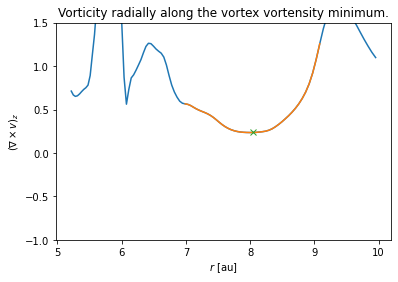

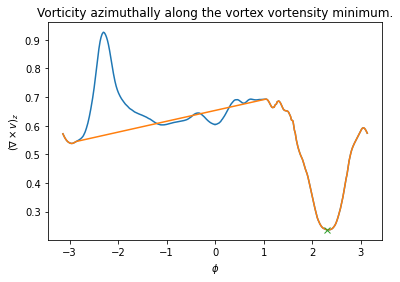

In [42]:
for vort in candidates.values():
    for v in ["mass_enhancement", "mass_background", "mass", "vortensity_min", "vortensity_median", "vortensity_mean", "vortensity_max"]:
        print(v, vort[v])
    mass = vort["mass"]/(1*u.jupiterMass).to_value("solMass")
    vort_med = vort["vortensity_median"]
    print("strength", np.exp(-vort_med)*mass)
    
    inds = contour["vortensity_min_inds"]
    
    mask = contour["mask"]
    mask_r = mask[:, inds[1]]
    mask_phi = mask[inds[0], :]
    
    vorticity_r = vorticity_view[:, inds[1]]
    vorticity_phi = vorticity_view[inds[0], :]
    
    fig, ax = plt.subplots()
    ax.plot(Xc_view[:,inds[1]], vorticity_r)
    ax.plot(Xc_view[:,inds[1]][mask_r], vorticity_r[mask_r])
    ax.plot([Xc_view[inds]],[vorticity_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$(\nabla \times v)_z$")
    ax.set_title("Vorticity radially along the vortex vortensity minimum.")
    ax.set_ylim([-1,1.5])
    
    fig, ax = plt.subplots()
    ax.plot(Yc_view[inds[0],:], vorticity_phi)
    ax.plot(Yc_view[inds[0],:][mask_phi], vorticity_phi[mask_phi])
    ax.plot([Yc_view[inds]],[vorticity_view[inds]], "x")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$(\nabla \times v)_z$")
    ax.set_title("Vorticity azimuthally along the vortex vortensity minimum.")
    break

## Extend mask to full data array size

In [46]:
for c in candidates.values():
    mask = c["mask"]
    gmask = np.concatenate(
        [np.zeros((vmi, mask.shape[1]),dtype=bool), 
        mask,
        np.zeros((Xc.shape[0]-vma, mask.shape[1]),dtype=bool)],
        axis=0)
    c["gmask"] = gmask
    c["gtop"] = (c["top"][0] + vmi, c["top"][1])
    c["gright"] = (c["right"][0] + vmi, c["right"][1])
    c["gleft"] = (c["left"][0] + vmi, c["left"][1])
    c["gbottom"] = (c["bottom"][0] + vmi, c["bottom"][1])

<ipython-input-47-cdc0c83178bd>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(Xc, Yc, vortensity,cmap=cmap,norm=norm)


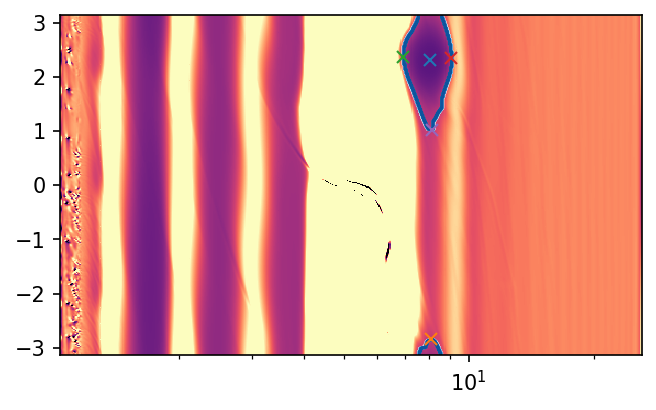

In [47]:
fig, ax = plt.subplots(figsize=(5,3),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=-0.5, vmax=1.5)
img = ax.pcolormesh(Xc, Yc, vortensity,cmap=cmap,norm=norm)

candidates_list = [c for c in candidates.values()]

for n, contour in enumerate(candidates_list):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc, Yc, contour["gmask"], cmap="Blues")
    x,y = contour["vortensity_min_pos"]
    ax.plot([x], [y], "x")
    for key in ["top", "left", "right", "bottom"]:
        key = "g" + key
        x = Xc[c[key]]
        y = Yc[c[key]]
        ax.plot([x], [y], "x")